In [1]:
# 211211 
# timm 채널 설정 : timm.create_model(CFG.model, pretrained=pretrained, num_classes=1, in_chans=1)
# iamge resize 효율 적

In [2]:
import os
files=os.listdir("../input/seti-breakthrough-listen")
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [3]:
import os
import sys
from PIL import Image
import cv2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
import albumentations as A

from sklearn.metrics import roc_auc_score

device="cuda"

In [4]:
def convert_image_id_2_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "../input/seti-breakthrough-listen/{}/{}/{}.npy".format(
        folder, image_id[0], image_id 
    )

In [5]:
train = pd.read_csv("../input/seti-breakthrough-listen/train_labels.csv")
train["path"]=train["id"].apply(lambda x: convert_image_id_2_path(x))
display(train)

,id,target,path
0,0000799a2b2c42d,0,../input/seti-breakthrough-listen/train/0/0000...
1,00042890562ff68,0,../input/seti-breakthrough-listen/train/0/0004...
2,0005364cdcb8e5b,0,../input/seti-breakthrough-listen/train/0/0005...
3,0007a5a46901c56,0,../input/seti-breakthrough-listen/train/0/0007...
4,0009283e145448e,0,../input/seti-breakthrough-listen/train/0/0009...
...,...,...,...
59995,fff8217fe05aba3,0,../input/seti-breakthrough-listen/train/f/fff8...
59996,fffa939e610ed70,0,../input/seti-breakthrough-listen/train/f/fffa...
59997,fffbb1c9c3d6c31,1,../input/seti-breakthrough-listen/train/f/fffb...
59998,fffc9a763d23647,0,../input/seti-breakthrough-listen/train/f/fffc...


0    54000
1     6000
Name: target, dtype: int64

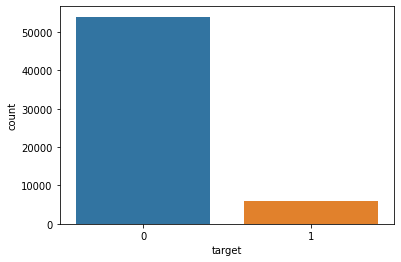

In [6]:
sns.countplot(data=train,x="target")
display(train.target.value_counts())

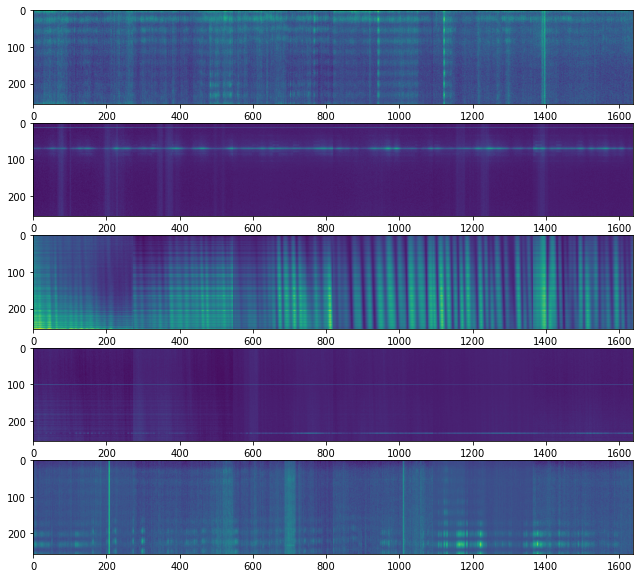

In [7]:
f,ax=plt.subplots(5,1,figsize=(20,10))
for i in range(5):
    img=np.load(train.loc[i,"path"])#(6,273,256)
    img=img.astype(np.float32)
    img=np.vstack(img).transpose((1,0))#(1638,256)->(256,1638)
    ax[i].imshow(img)

# ROC Test

In [8]:
from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [9]:
cancer = load_breast_cancer()

X = cancer.data[:-100]
y = cancer.target[:-100]
X_test = cancer.data[-100:]
y_test = cancer.target[-100:]

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X, y)

y_preds = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_preds))
print(roc_auc_score(y_test,y_preds))

[02:17:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[23  0]
 [ 0 77]]
1.0


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


roc auc score: 1.0


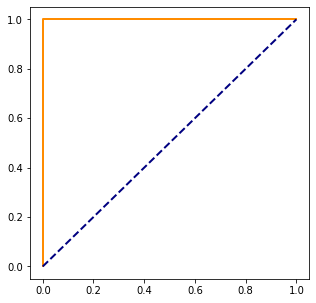

In [10]:
fpr, tpr, _ = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
print(f"roc auc score: {roc_auc_score(y_test,y_preds)}")

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Data

In [11]:
import random
import os
def random_seed(SEED):
    
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

random_seed(42)

In [12]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=5)
train["fold"]=-1
X=train.sample(frac=1.)
y=train.target
for i,(_,val_idx) in enumerate(skf.split(X,y)):
    train.loc[val_idx,"fold"]=i 

# Data Loader

In [13]:
class SetiDataset(Dataset):
    def __init__(self, df, transform=None, conf=None):
        self.df = df.reset_index(drop=True)
        self.labels = df['target'].values
        self.dir_names = df['path'].values
        self.transform = transform
        self.conf = conf
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        file_path = self.df.loc[idx,"path"]
#1        
#         image = np.load(file_path)#(6,273,256)
#         image=np.vstack(img).transpose((1,0))#(1638,256)->(256,1638)
    
#         if self.transform is not None:
#             image = self.transform(image=image)['image']
        
#         image = torch.tensor(image,dtype=torch.float32)
#         label = torch.tensor([self.labels[idx]]).float()

#2 method
        image = np.load(file_path)
        image = image.astype(np.float32)
        image = np.vstack(image).transpose((1, 0))
        img_pl = Image.fromarray(image).resize((384, 384), resample=Image.BICUBIC)
        image = np.array(img_pl)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = torch.from_numpy(image).unsqueeze(dim=0)
        label = torch.tensor([self.labels[idx]]).float()
        
        return {
            "x":image, 
            "y":label
        }

In [14]:
#dataset test
fold=0
train_df=train[train.fold!=fold].reset_index(drop=True)
valid_df=train[train.fold==fold].reset_index(drop=True)

In [15]:
train_dataset=SetiDataset(train_df)
valid_dataset=SetiDataset(valid_df)

In [16]:
#data loader
train_loader=torch.utils.data.DataLoader(
    train_dataset,batch_size=8,num_workers=4,shuffle=True
)
valid_loader=torch.utils.data.DataLoader(
    valid_dataset,batch_size=8,num_workers=4,shuffle=False
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
for a in train_loader:
    print(a["x"].shape, a["y"].shape)
    break

torch.Size([8, 1, 384, 384]) torch.Size([8, 1])


# Model

In [18]:
class CFG:
    model_test=False
    frac=1.#0.02 #1.0#
    train=True#False#
    pretrained=True #False#
#     model= "tf_efficientnet_b0"
    model= "tf_efficientnet_b4"#"resnet18"
    train_bs=16
    valid_bs=8#12
    test_bs=8
    epoch=40
    fold=[0]
    classes=1
    seed= 719
    lr=2e-4
    es=4

In [19]:
## Model
import torch
import torch.nn as nn
import torchvision

def get_model(classes=1,pretrained=True):
    classes=classes
    base_model=timm.create_model(CFG.model, pretrained=pretrained, num_classes=1, in_chans=1)
    return base_model 

In [20]:
model=get_model()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_aa-818f208c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_aa-818f208c.pth


In [21]:
if CFG.model_test:
    model.to(device)
    model.train()

    for a in train_loader:
        x=a["x"].to(device)
        y=a["y"].to(device)
        output=model(x)
        break

    print(output.squeeze(-1).shape)

# Train Fuction

In [22]:
def loss_fn(outputs,targets):
    return nn.BCEWithLogitsLoss()(outputs,targets)

In [23]:
## Engine
from tqdm import tqdm
class Engine:
    def __init__(self,model,optimizer,scheduler=None):
        self.model=model
        self.optimizer=optimizer
        self.scheduler=scheduler
        self.device=device

    def train(self,data_loader):
        self.model.train()
        final_loss=0
        for data in tqdm(data_loader):
            self.optimizer.zero_grad()
            inputs=data["x"].to(self.device)
            targets=data["y"].to(self.device)
            outputs=self.model(inputs)
            loss=loss_fn(outputs,targets)
            loss.backward()
            self.optimizer.step()
            final_loss += loss.item()
        return final_loss/len(data_loader)
    
    def validate(self,data_loader):
        self.model.eval()
        final_loss=0
        for data in tqdm(data_loader):
            inputs=data["x"].to(self.device)
            targets=data["y"].to(self.device)
            outputs=self.model(inputs)
            loss=loss_fn(outputs,targets)
            final_loss += loss.item()
        return final_loss/len(data_loader)

In [24]:
def get_dataset(fold=0):
    train_df=train[train.fold!=fold].reset_index(drop=True).sample(frac=CFG.frac)
    valid_df=train[train.fold==fold].reset_index(drop=True).sample(frac=CFG.frac)

    train_dataset=SetiDataset(train_df)
    valid_dataset=SetiDataset(valid_df)

    train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=CFG.train_bs,num_workers=4,shuffle=True)
    valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=CFG.valid_bs,num_workers=4,shuffle=False)
    return train_loader,valid_loader

In [25]:
def loop_train(fold,save_model=False):
    # Dataset
    train_loader,valid_loader=get_dataset(fold)
    model=get_model()
    model.to("cuda")

    # Model,Optimizer, scheduler, engine
    optimizer=torch.optim.Adam(model.parameters(),lr=3e-4)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,patience=3,threshold=1e-5,mode="min",verbose=True)
    engine=Engine(model,optimizer,scheduler)
    best_loss=np.inf
    early_stopping=10
    early_stopping_cnt=0

    for epoch in range(CFG.epoch):
        train_loss=engine.train(train_loader)
        valid_loss=engine.validate(valid_loader)
        scheduler.step(valid_loss)

        if valid_loss<best_loss:
            best_loss=valid_loss
            torch.save(model.state_dict(),f"model_{CFG.model}_fold_{fold}.bin")
            print(f"fold={fold}, epoch={epoch}, train_loss={train_loss:.6f}, valid_loss={valid_loss:.6f}")    
            early_stopping_cnt=0
        else:
            early_stopping_cnt+=1
        if early_stopping_cnt>early_stopping:
            break

    print(f"fold={fold}, best val loss={best_loss}")

In [26]:
for fold in CFG.fold:
    print(f"fold :{fold}")
    loop_train(fold,save_model=True)

fold :0


100%|██████████| 30/30 [00:04<00:00,  6.94it/s]


fold=0, epoch=0, train_loss=1.292046, valid_loss=1.194111


100%|██████████| 30/30 [00:03<00:00,  9.03it/s]


fold=0, epoch=1, train_loss=0.349778, valid_loss=1.035050


100%|██████████| 30/30 [00:03<00:00,  7.80it/s]


Epoch     6: reducing learning rate of group 0 to 3.0000e-05.


 45%|████▌     | 27/60 [00:14<00:17,  1.92it/s]


KeyboardInterrupt: 

# predict

In [38]:
test = pd.read_csv("../input/seti-breakthrough-listen/sample_submission.csv")
test["path"]=test["id"].apply(lambda x: convert_image_id_2_path(x,False))

In [39]:
def get_dataset_test():
    test_dataset=SetiDataset(test)
    test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=CFG.test_bs,num_workers=4,shuffle=False)
    return test_loader

In [41]:
def predict(model,dataloader):
    model.to(device)
    model.eval()
    preds=[]
        
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs=data["x"].to(device)
            outputs=model(inputs)
            outputs=outputs.squeeze(-1)
            preds.append(outputs.cpu().detach().numpy())
        preds=np.concatenate(preds)

    return preds

In [42]:
data_loader=get_dataset_test()

all_preds=[]
for fold in CFG.fold:
    model=get_model()
    path=f"./model_{CFG.model}_fold_{fold}.bin"
    model.load_state_dict(torch.load(path))

    preds=predict(model,data_loader)
    all_preds.append(preds)

100%|██████████| 500/500 [00:48<00:00, 10.33it/s]


In [46]:
p=np.array(all_preds).T
preds=np.average(p,axis=1)

In [ ]:
test["target"]=preds
test[["id","target"]].to_csv("submission.csv",index=False)
test.head()